In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm

from scipy.special import expit as logistic

In [2]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

In [3]:
az.style.use('arviz-darkgrid')

In [4]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

##### <center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Modelado Jerárquico</h1>
<h2 align="center">Agrupamiento parcial de datos</h2> 
    


<br>
<br>
<br>
<br>
<br>

## Objetivos

* Aprender a construir modelos jerárquicos
* Discutir el concepto de contracción y regularización.
* Discutir las implicaciones de agrupar parcialmente los datos

## Modelos Jerárquicos

<center>
<img src="img/pooling.png" width=500>


<center>
<img src="img/hierarchical_model.png" width=500>

## Corrimientos químicos jerárquicos 

<br>


* Las proteínas son moléculas formadas por un número variable de 20 unidades en un orden variable.


* Para cada una de estas unidades podemos medir un "corrimiento químico" y también podemos calcularlo usando métodos de Química Cuántica


* Como cada una de las 20 unidades son químicamente diferentes, existe variabilidad entre unidades


* Como el entorno químico (la proteína) modula el valor de un corrimiento químico, existe variabilidad dentro de cada unidad

In [5]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

cs_data.tail()

,ID,aa,theo,exp
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36
1775,1KS9,SER,58.07,60.55


In [6]:
with pm.Model() as cs_nh:         
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 
 
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 
     
    trace_cs_nh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


In [7]:
with pm.Model() as cs_h:
    # hiper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sd=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ, μ_sd, μ_mu]


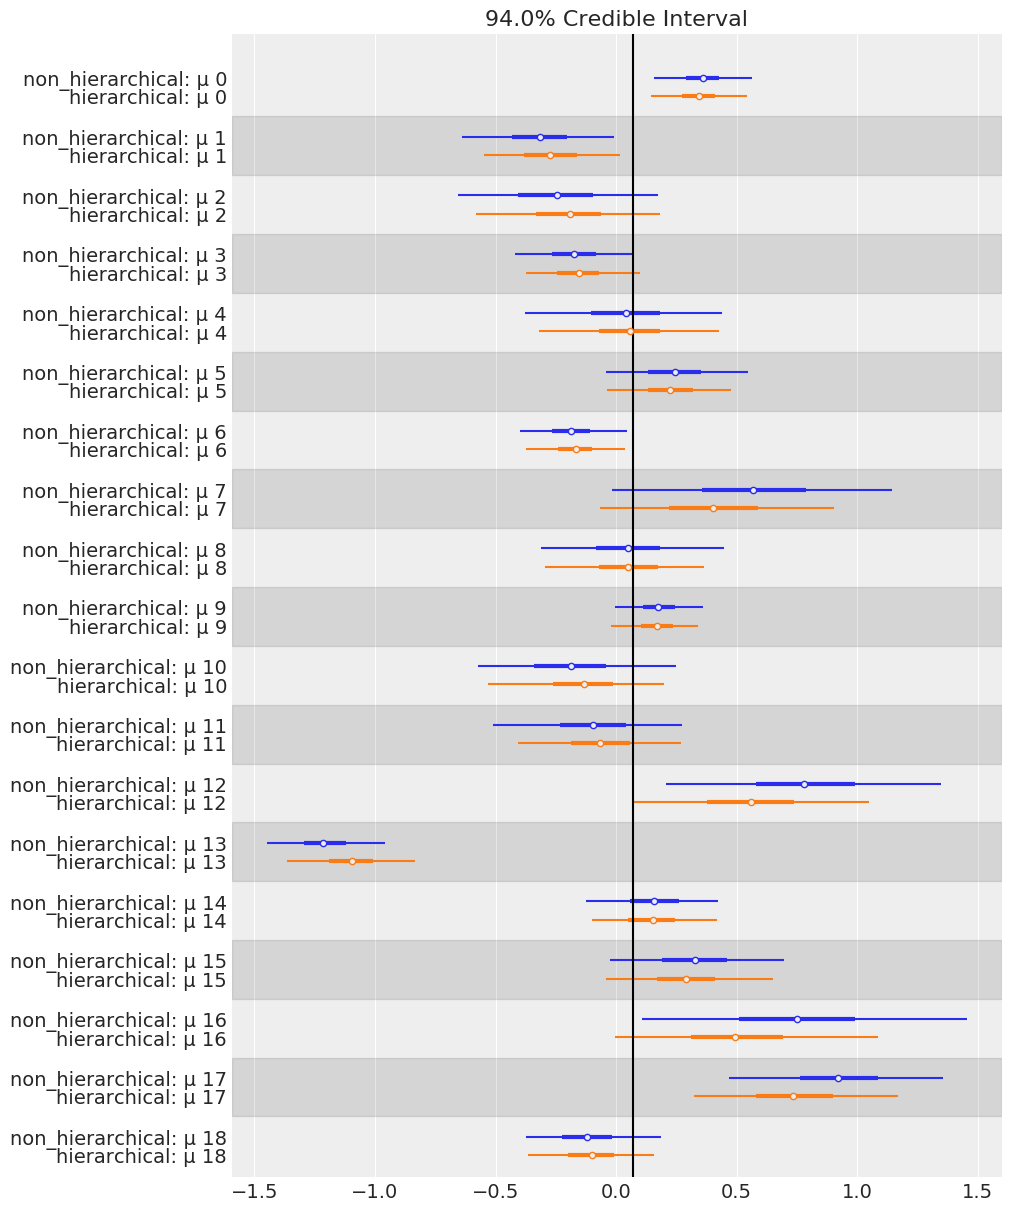

In [8]:
axes = az.plot_forest([trace_cs_nh, trace_cs_h], model_names=['non_hierarchical', 'hierarchical'],
              var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 12),
              colors='cycle');
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_mu'].mean(), *y_lims);

## Contracción y ventajas de los modelos jerárquicos

<br>


* Cada grupo informa a los demás y es informado por los demás.


* La estimación de cada grupo se contrae hacia la media común


* La fuerza de la contracción no es la misma para todos los grupos
     * Los grupos típicos están menos afectados.
     * Los grupos con muestras de mayor tamaño se ven menos afectados.


* Conservar la variación a nivel de grupo y entre grupos


* El modelo jerárquico es una forma de regularización.

## Renacuajos multinivel

<br>
<br>

* Tenemos 48 tanques llenos de renacuajos


* Queremos modelar la probabilidad de supervivencia


* Las condiciones como la temperatura, el pH, la luz, etc. varían ligeramente entre los tanques (pero no los estamos teniendo en cuenta explícitamente)


* Podemos pensar en cada tanque como un grupo


<br>


[statistical rethinking](https://xcelab.net/rm/statistical-rethinking/)

In [9]:
d = pd.read_csv('../datos/reedfrogs.csv', sep=",")
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [10]:
with pm.Model() as modelo_renacuajos:
    # Hiperpriors
    μ = pm.Normal('μ', 0., 1.)
    σ = pm.HalfNormal('σ', 10.)
    # Prior
    α_tanque = pm.Normal('α_tanque', μ, σ, shape=d.shape[0])
    p = pm.Deterministic('p', pm.math.sigmoid(α_tanque))  # transformación logistica
    #likelihood
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    trace_renacuajos = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α_tanque, σ, μ]


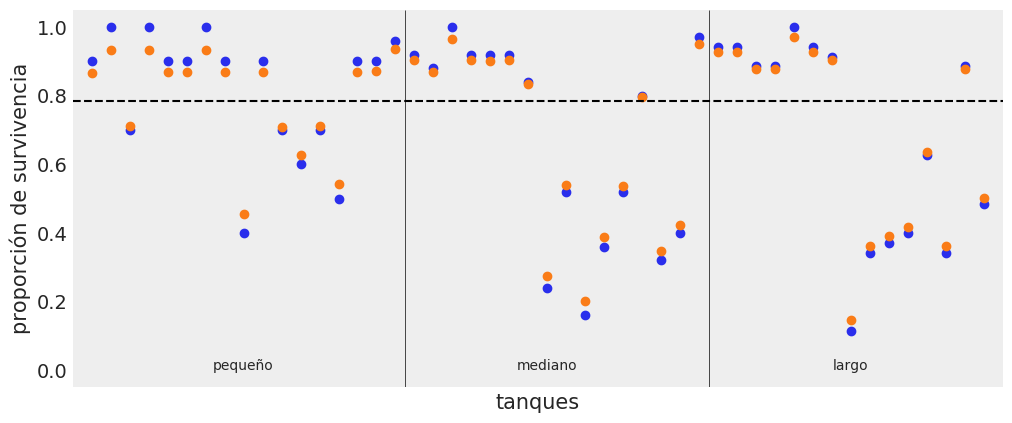

In [11]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.scatter(np.arange(0, 48), d.propsurv, color='C0')
ax.scatter(np.arange(0, 48), np.mean(trace_renacuajos['p'], 0), color='C1')
ax.hlines(logistic(np.median(trace_renacuajos['μ'], axis=0)), -1, 49, linestyles='--')

idx = d.density[d.density.diff() > 0].index
ax.vlines(idx + 0.5, -.05, 1.05, lw=.5)
for i, t in zip(np.linspace(0, 48, 7)[1::2], ('pequeño', 'mediano', 'largo')):
    ax.text(i, 0, t, horizontalalignment='center')
ax.set_xlabel('tanques')
ax.set_ylabel('proporción de survivencia')
ax.set_xlim(-1, 48)
ax.set_xticks([])
ax.set_ylim(-.05, 1.05)
ax.grid(False)

## Monedas jerárquicas

<img src="img/modelo_3_monedas_jerarquico.png" width=250>


\begin{align}
\mu &\sim \operatorname{Beta}(\alpha, \beta) \\
\kappa &\sim \operatorname{Gamma}(s, r) \\
\theta &\sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

[Doing Bayesian Data Analysis](https://sites.google.com/site/doingbayesiandataanalysis/)

In [12]:
N = [30, 30, 30]  # Número de tiradas por moneda
z = [3, 3, 3]  # Número de caras por moneda

# vector índice
monedas = np.repeat(np.arange(len(N)), N)
# Lista llena de ceros (cecas) y unos (caras)
datos = []
for i in range(len(N)):
    datos.extend(np.repeat([1, 0], [z[i], N[i]-z[i]]))

In [13]:
with pm.Model() as modelo_j:
    # hiperparámetros
    μ = pm.Beta('μ', 2., 2.)
    κ = pm.HalfNormal('κ', 10.)

    # priors
    θ = pm.Beta('θ', μ * κ, (1 - μ) * κ, shape=len(N))
    # likelihood
    y = pm.Bernoulli('y', p=θ[monedas], observed=datos)

    trace_j = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, κ, μ]


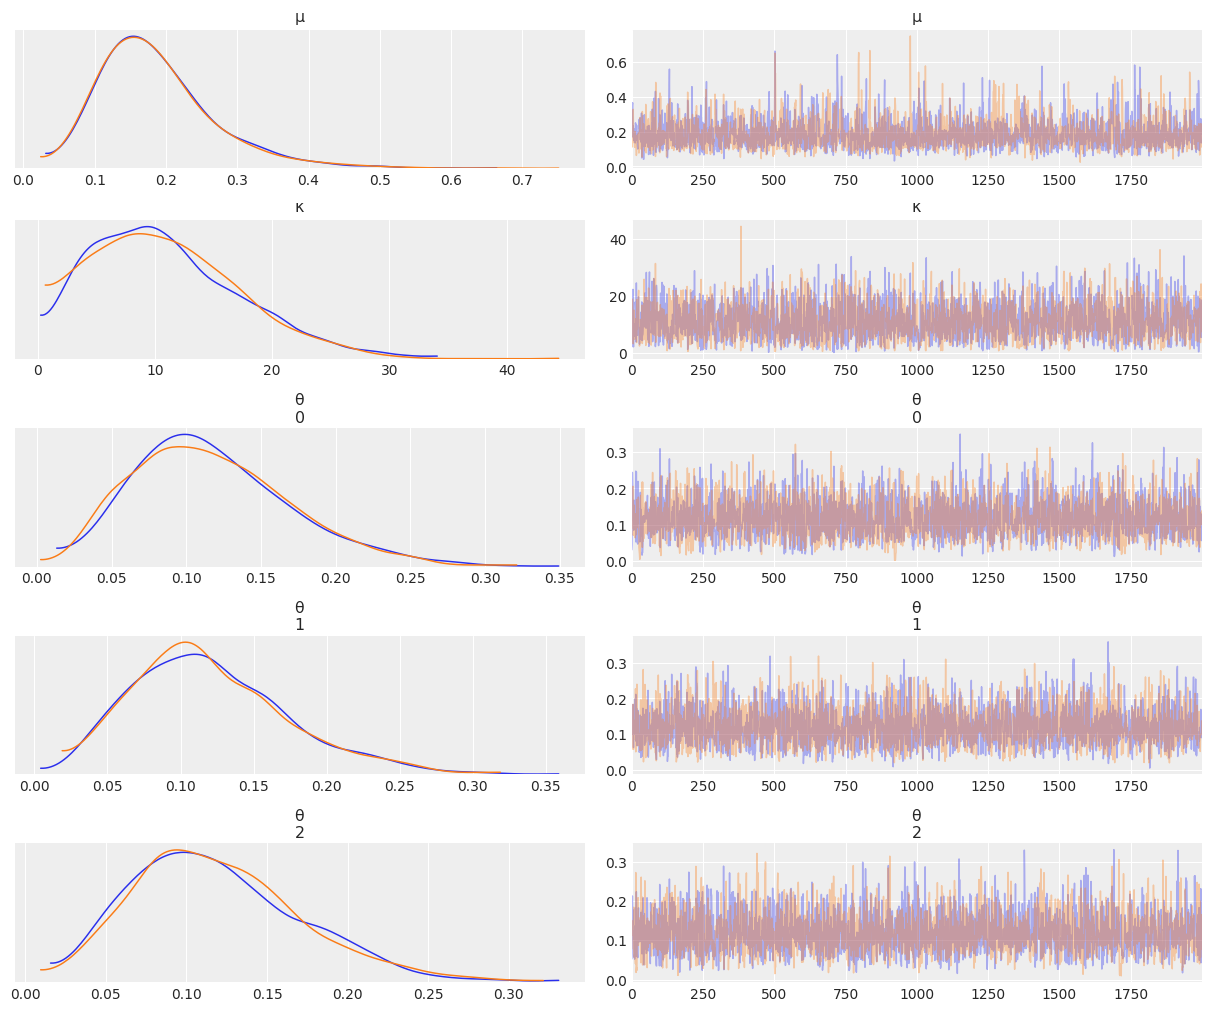

In [14]:
az.plot_trace(trace_j);

In [15]:
az.summary(trace_j, kind='stats')

,mean,sd,hpd_3%,hpd_97%
μ,0.187,0.082,0.056,0.334
κ,10.994,6.224,0.771,22.021
θ[0],0.117,0.052,0.029,0.218
θ[1],0.120,0.053,0.031,0.222
θ[2],0.119,0.052,0.035,0.220


## Ejercicios

1. En el modelo `cs_h` ¿Cuál de los siguientes priors generará mayor *contracción* μ = Normal(0, 0.5) o μ = Normal(0, 1). Justificar

2. Convierte el modelo de las propinas del notebook anterior en un modelo jerárquico (agrupando los días de la semana).

3. Convierte los siguiente modelos a modelos jerárquicos.

a.
\begin{align*}
\alpha_{grupo} &\sim Normal(0, 10) \\
\beta &\sim Normal(0, 1) \\
p_i  &= \text{logistic}(\alpha_{grupo[i]} + \beta x_i) \\
y_i &\sim Binomial(1, p_i ) \\
\end{align*}



b.
\begin{align*}
\alpha_{grupo} \sim Normal(0, 10) \\
\beta \sim Normal(0, 1) \\
\sigma \sim HalfCauchy(0, 2) \\
\mu_i = \alpha_{grupo[i]} + \beta x_i \\
y_i \sim Normal(\mu_i , \sigma) \\
\end{align*}


4. Repetí el ejemplo de las monedas jerárquicas, esta vez use los siguientes datos:
    * z = [3,3,3] 
    * z = [18,3,18]

Registrá el valor de las medias estimadas para $\theta$, para que puedas comparar los 3 ejemplos (incluyendo `z = [18,18,18]`)